In [1]:
import sys
sys.path.append("../../src")
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.animation as animation 
import pickle
import pandas as pd
from scipy.sparse import spdiags
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
import subprocess
from time import time
from copy import deepcopy
from sindy_utils import *

In [2]:
plot_fig = True
save_data = True
tstop = 3
dt = 1e-2
nt = int(tstop / dt + 1)
t = np.linspace(0, tstop, nt)

# parameters
# p1_arr = np.array([1.5]) # w1 of initial condition
# p2_arr = np.array([2]) # w2 of initial condition

p1_arr = np.linspace(1.5, 2.0, 4) # w1 of initial condition
p2_arr = np.linspace(2, 2.5, 4) # w2 of initial condition


params = {}
params['pde'] = {}
params['pde']['exe_file'] = '../../src/ex9'
params['pde']['m_file'] = './periodic-square.mesh'
params['pde']['u_file'] = './ex9-u_pred.gf'
params['pde']['res_file'] = "./ex9-residual.gf"
params['pde']['prob'] = 3
params['pde']['rl'] = 4
params['pde']['order'] = 1
params['pde']['tstop'] = tstop
params['pde']['dt'] = dt

In [3]:
def plot_u(u, du):
    vmin_x = u.min()
    vmax_x = u.max()
    vmin_dx = du.min()/1
    vmax_dx = du.max()/1
    
    fig = plt.figure(figsize=(18,3))
    ax = fig.add_subplot(141)
    ax.set_aspect('equal')
    plt.axis('off')
    ax.set_title(f'u - t: {0}')
    tpc = ax.tripcolor(triang, u[0], shading='gouraud', vmin=vmin_x, vmax=vmax_x)
    fig.colorbar(tpc, ax=ax)
    
    ax = fig.add_subplot(142)
    ax.set_aspect('equal')
    plt.axis('off')
    ax.set_title(f'u - t: {u.shape[0]}')
    tpc = ax.tripcolor(triang, u[-1], shading='gouraud', vmin=vmin_x, vmax=vmax_x)
    fig.colorbar(tpc, ax=ax)
    
    ax = fig.add_subplot(143)
    ax.set_aspect('equal')
    plt.axis('off')
    ax.set_title(f'du - t: {0}')
    tpc = ax.tripcolor(triang, du[0], shading='gouraud', vmin=vmin_dx, vmax=vmax_dx)
    fig.colorbar(tpc, ax=ax)
    
    ax = fig.add_subplot(144)
    ax.set_aspect('equal')
    plt.axis('off')
    ax.set_title(f'du - t: {u.shape[0]}')
    tpc = ax.tripcolor(triang, du[-1], shading='gouraud', vmin=vmin_dx, vmax=vmax_dx)
    fig.colorbar(tpc, ax=ax)
    
    plt.tight_layout()
#     plt.savefig('./fig/u_vs_time_2d.png')
    plt.show()

case 1 - w1: 1.5, w2: 2.0
-0.9974165962316163 0.9975962323073081 -0.5882060192283931 0.650737343198923


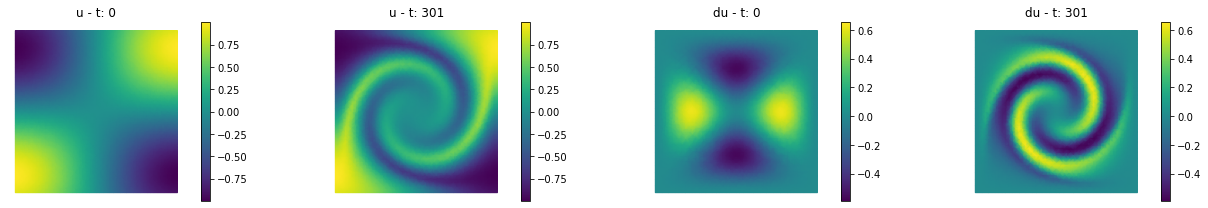

case 2 - w1: 1.5, w2: 2.1666666666666665
-0.9968843170791852 0.9970285403644671 -0.6134938731473755 0.7060850063766875


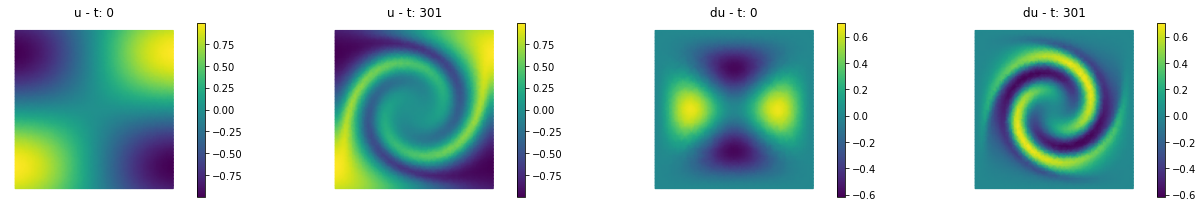

case 3 - w1: 1.5, w2: 2.3333333333333335
-0.99739242473945 0.9976798414698208 -0.6359328892158197 0.7616735703620655


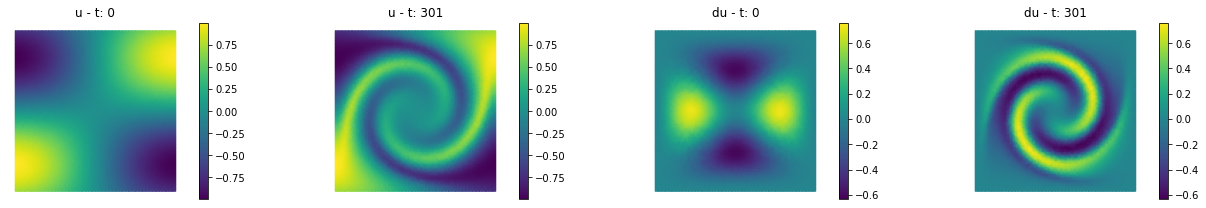

case 4 - w1: 1.5, w2: 2.5
-0.9974789579487924 0.9978481339664881 -0.6547717707191636 0.8175110346970941


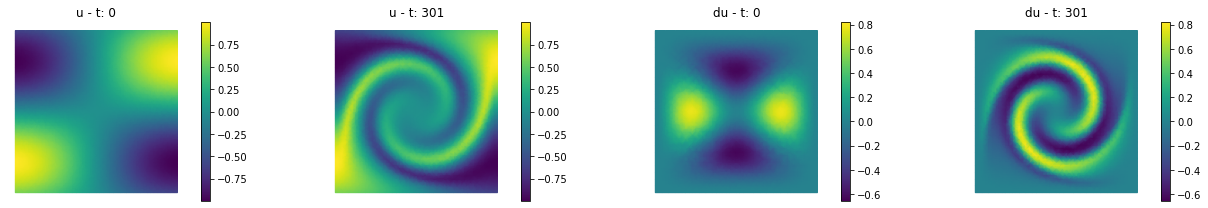

case 5 - w1: 1.6666666666666667, w2: 2.0
-1.0004578668470927 0.9999960718676295 -0.6542858304771949 0.701226185037617


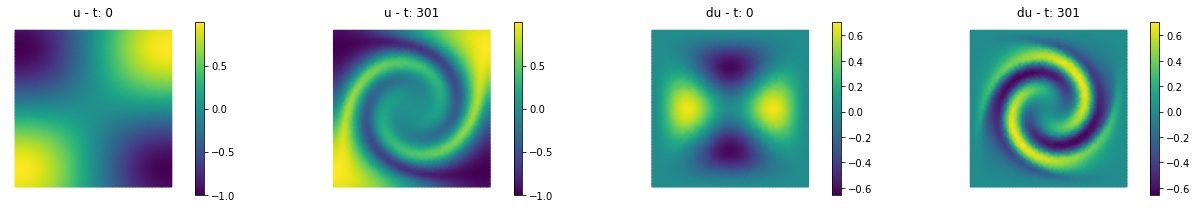

case 6 - w1: 1.6666666666666667, w2: 2.1666666666666665
-1.000787977687693 1.00047511202863 -0.6824395790396877 0.7608947613504513


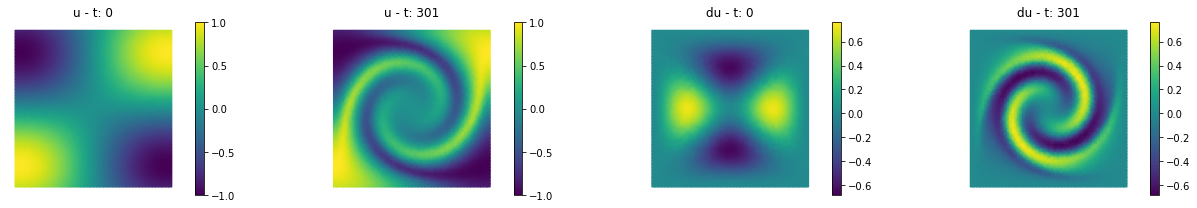

case 7 - w1: 1.6666666666666667, w2: 2.3333333333333335
-1.0008867501184286 1.001030481549609 -0.7071769821361233 0.8208291808974678


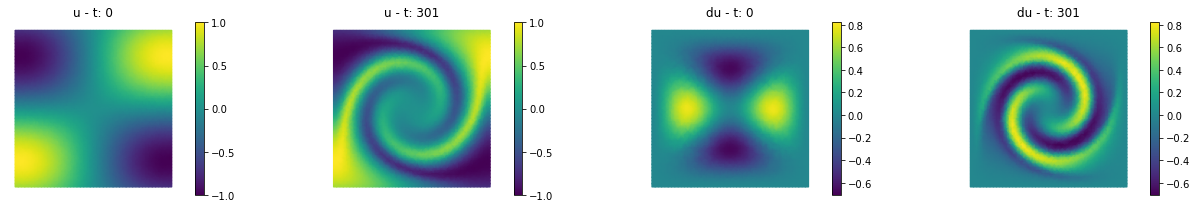

case 8 - w1: 1.6666666666666667, w2: 2.5
-1.001469897148533 1.0013134922170654 -0.728161796711141 0.88103848731663


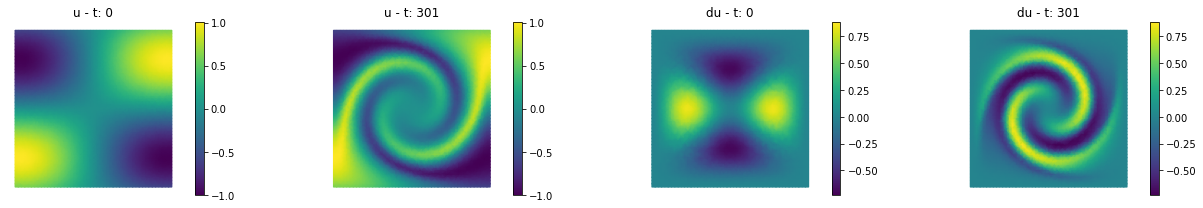

case 9 - w1: 1.8333333333333333, w2: 2.0
-1.0012694089044283 1.0010813418545927 -0.7205773503092713 0.7466467730731052


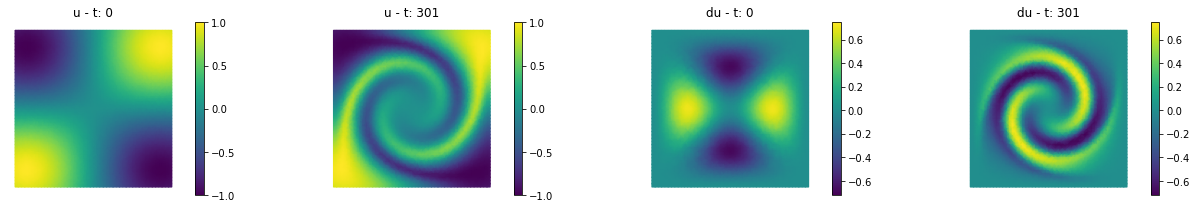

case 10 - w1: 1.8333333333333333, w2: 2.1666666666666665
-1.0022854684506939 1.0011376789920237 -0.7516138437995102 0.8099340881507759


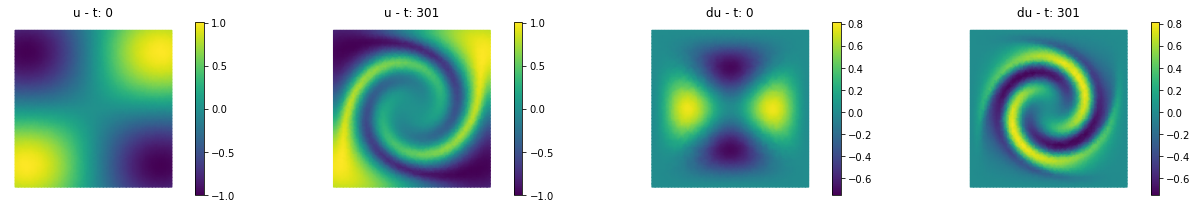

case 11 - w1: 1.8333333333333333, w2: 2.3333333333333335
-1.0031951203836658 1.0018430792946995 -0.7785854081432019 0.8734505492014184


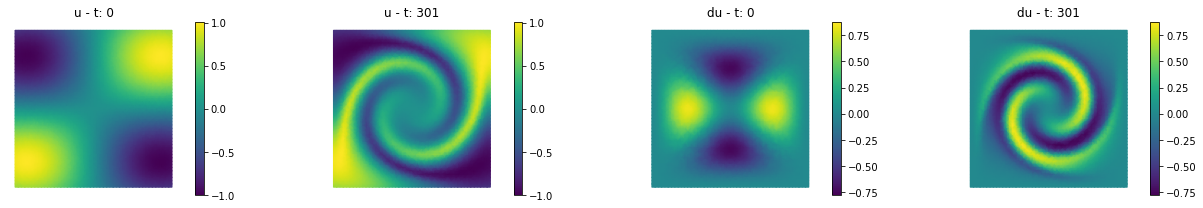

case 12 - w1: 1.8333333333333333, w2: 2.5
-1.004640209651615 1.0037197524073111 -0.8017318839113099 0.9372061458830252


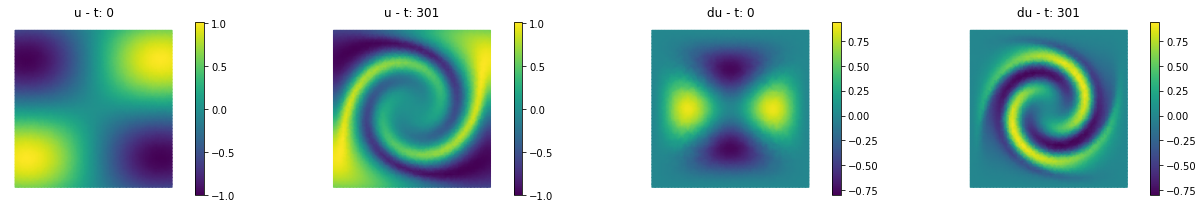

case 13 - w1: 2.0, w2: 2.0
-1.0015894604022433 1.001589460402243 -0.787093460773494 0.7870934607734926


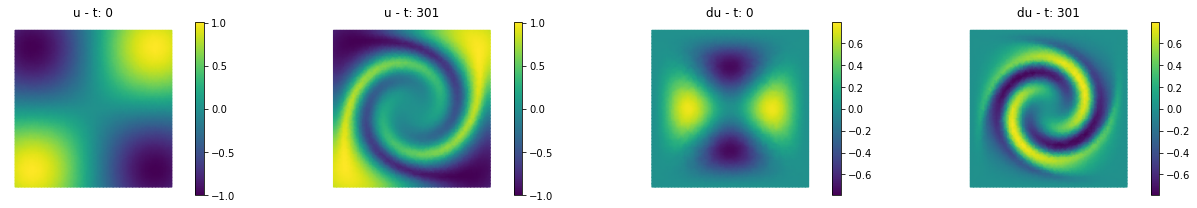

case 14 - w1: 2.0, w2: 2.1666666666666665
-1.0048260803202544 1.005501887006657 -0.8210308006435485 0.8538447474595908


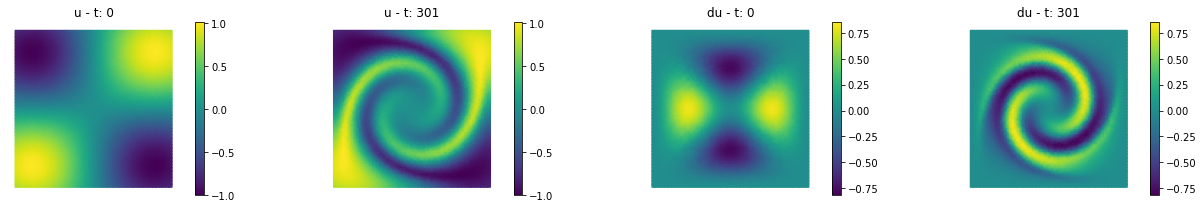

case 15 - w1: 2.0, w2: 2.3333333333333335
-1.0080679043409737 1.0086294310030637 -0.8501646075022886 0.9208393234438796


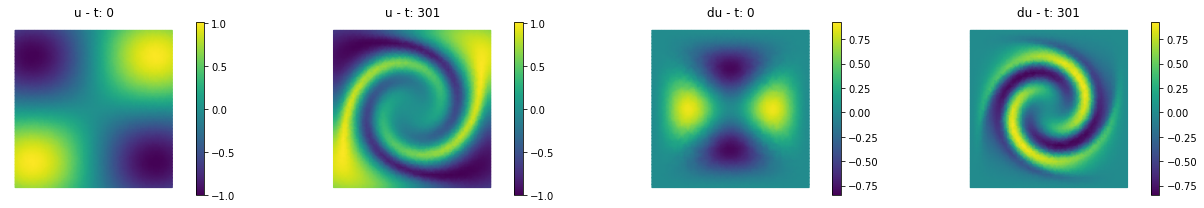

case 16 - w1: 2.0, w2: 2.5
-1.0114105150866757 1.012827459251655 -0.8754895917498208 0.988095087759731


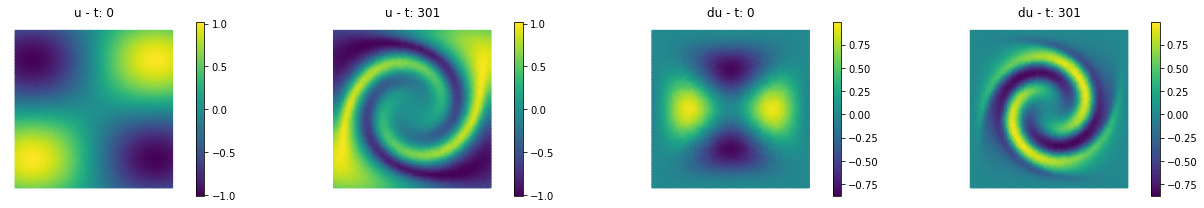

average time for computing x: 3.74 s
(301, 9216) (301, 9216)


In [4]:
# generate training set
data = []
param = []
total_time = 0
case_id = 1
for i in p1_arr:
    for j in p2_arr:
        snapshot = {}
        param.append(np.array([i, j]))
        params['pde']['w1'] = i
        params['pde']['w2'] = j
        print(f'case {case_id} - w1: {i}, w2: {j}')
        
        # compute u and du
        time0 = time()
        subprocess.call([params['pde']['exe_file'],
                         '-m', params['pde']['m_file'],
                         '-uf', params['pde']['u_file'],
                         '-rf', params['pde']['res_file'],
                         '-p', str(params['pde']['prob']),
                         '-r', str(params['pde']['rl']),
                         '-o', str(params['pde']['order']),
                         '-tf', str(params['pde']['tstop']),
                         '-dt', str(params['pde']['dt']),
                         '-w1', str(params['pde']['w1']),
                         '-w2', str(params['pde']['w2']),
                         '-no-vis',
                         '-no-visit',])
        time1 = time()
        t_fom = time1 - time0
        total_time += t_fom
        
        # collect data
        snapshot = {}
        u_all = []
        du_all = []
        for k in range(int(nt)):
            u = np.loadtxt(f'./ex9-u_{k:d}.gf', skiprows=5, dtype='float')
            u_all.append(u)
        u_all = np.vstack(u_all)
        du_all = derivative(u_all, tstop)
    
        # Normalize u and du to [0,1], MinMaxScaler transforms features by scaling each feature to a given range.       
        snapshot['x'] = u_all
        snapshot['dx'] = du_all
        snapshot['t'] = np.linspace(0,tstop,u_all.shape[0])
        snapshot['time_fom'] = t_fom
        print(u_all.min(), u_all.max(), du_all.min(), du_all.max())
        data.append(snapshot)
        
        # triangulation for plotting
        # will generate vertex.txt that contains nodal coordinates
        if case_id == 1:
            mesh = pd.read_csv('ex9.mesh')
            idx = mesh[mesh.iloc[:,0].str.startswith('vertices')].index[0]
            vert = mesh.iloc[idx+7:,:] # nodal coordinates
            vert.to_csv('/g/g92/he10/Research/data/MFEMex9/vertex.txt', index=False, header=False)
            vert = np.array([x.split(' ') for x in vert.to_numpy()[:,0]], dtype=float)
            triang = tri.Triangulation(vert[:,0], vert[:,1])
            
        if plot_fig:
            plot_u(u_all, du_all)
        case_id += 1
        
data_all = {}
data_all['data'] = data
data_all['param'] = param
print(f"average time for computing x: {total_time/len(data_all['data']):.2f} s")
print(snapshot['x'].shape, snapshot['dx'].shape) 

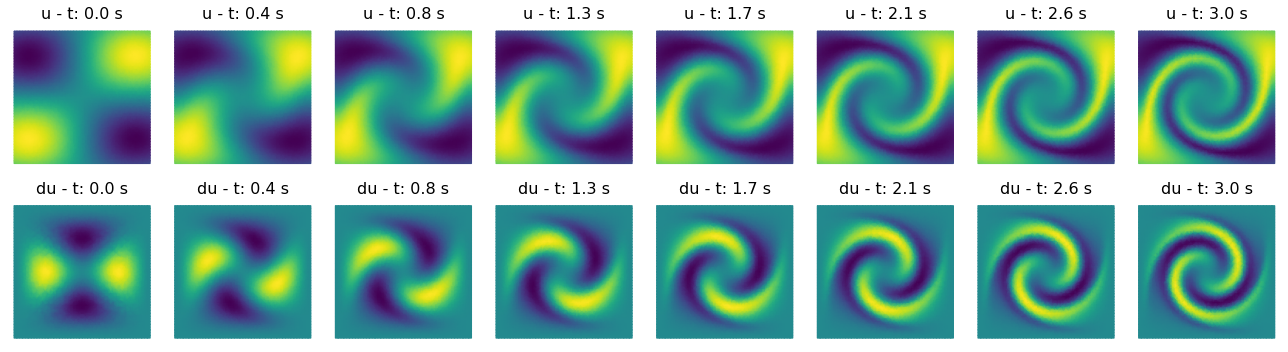

In [5]:
nplot = 8
step_list = np.linspace(0,nt-1,nplot,dtype=int)

fig = plt.figure(figsize=(18,5))
for i,step in enumerate(step_list):
    ax = fig.add_subplot(2,nplot,i+1)
    ax = plt.gca()
    tpc = ax.tripcolor(triang, u_all[step], shading='gouraud')
    ax.set_title(f'u - t: {step/nt*tstop:.1f} s',fontsize=16)
    plt.axis('off')
    
for i,step in enumerate(step_list):
    ax = fig.add_subplot(2,nplot,i+1+nplot)
    ax = plt.gca()
    tpc = ax.tripcolor(triang, du_all[step], shading='gouraud')
    ax.set_title(f'du - t: {step/nt*tstop:.1f} s',fontsize=16)
    plt.axis('off')
    
plt.tight_layout()
# plt.savefig('./ex9_multisteps.png')

In [6]:
# remove *.gf and *.mesh files output from executable
import glob
files = glob.glob('ex9*')
subprocess.call(['rm', '-r'] + files)

0

In [7]:
# save data
if save_data:
    num_case = len(data)
    data_path = '/g/g92/he10/Research/data/MFEMex9'
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    if num_case > 1:
        pickle.dump(data_all, open(data_path+f"/local{num_case}_tstop{tstop:.1f}.p", "wb"))
    else:
        pickle.dump(data_all, open(data_path+f"/local{num_case}_p1{p1_arr[0]:.1f}_p2{p2_arr[0]:.1f}_tstop{tstop:.1f}.p", "wb"))